In [ ]:
import os
import re
from pathlib import Path
from PIL import Image
from bs4 import BeautifulSoup
from svg.path import parse_path
import shutil
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import random

In [ ]:
building_element_names = ['Door', 'Wall', 'Window']
classes_lut = {'Door': 0, 'Wall': 1, 'Window': 2}

In [ ]:
def write(file, content):
    with open(file, 'w') as outfile:
        outfile.write(content)

In [ ]:
def bounding_box(xs, ys):
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    w, h = x_max - x_min, y_max - y_min
    return x_min + (w / 2), y_min + (h / 2), w, h

In [ ]:
def convert_polygon_string(text):
    xs, ys = [], []
    for p in text.split(" "):
        if "," not in p: continue
        e = p.split(",")
        if len(e) == 2:
            xs.append(float(e[0]))
            ys.append(float(e[1]))
    return xs, ys

In [ ]:
def arc_to_xys(path):
    xs, ys = [], []
    for segment in path:
        xs.extend([segment.start.real, segment.end.real])
        ys.extend([segment.start.imag, segment.end.imag])
    return xs, ys

In [ ]:
def post_process(index, img_width, img_height, cx, cy, w, h):
    return f"{index} {cx / img_width} {cy / img_height} {w / img_width} {h / img_height}"

In [ ]:
def create_annotation(svg):
    data_path = Path(svg).parent
    annotations = []
    try:
        pngs = list(data_path.glob('*scaled.png'))
        if not pngs: return
        img_path = pngs[0]
        with Image.open(img_path) as im:
            img_width, img_height = im.size
        
        with open(svg, "r") as file:
            soup = BeautifulSoup(file.read(), features="xml")
        
        for name in building_element_names:
            elements = soup.find_all(id=name)
            for element in elements:
                id_cls = classes_lut[name]
                xs, ys = [], []
                
                polygons = element.findChildren("polygon", recursive=False)
                for poly in polygons:
                    px, py = convert_polygon_string(poly["points"])
                    xs.extend(px); ys.extend(py)
                
                paths = element.findChildren("path", recursive=True)
                for path in paths:
                    try:
                        arc = parse_path(path["d"])
                        ax, ay = arc_to_xys(arc)
                        xs.extend(ax); ys.extend(ay)
                    except: continue
                
                if xs and ys:
                    cx, cy, w, h = bounding_box(xs, ys)
                    annotations.append(post_process(id_cls, img_width, img_height, cx, cy, w, h))
        
        write(os.path.join(data_path, img_path.stem + ".txt"), "\n".join(annotations))
    except Exception as e:
        print(f"Error {svg}: {e}")

In [1]:
svg_files = sorted(list(Path('cubicasa5k').glob('**/*.svg')))
for svg in svg_files:
    if (svg_files.index(svg) % 500 == 0): print(f"Progress: {svg_files.index(svg)}/{len(svg_files)}")
    create_annotation(svg)
print("Annotation generation complete.")

Progress: 0/5000
Progress: 500/5000
Progress: 1000/5000
Progress: 1500/5000
Progress: 2000/5000


C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (90344064 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Progress: 2500/5000
Progress: 3000/5000
Progress: 3500/5000
Progress: 4000/5000
Progress: 4500/5000
Annotation generation complete.


In [2]:
base_path = Path('cubicasa5k')
flat_dir = base_path / 'flat'

if flat_dir.exists():
    shutil.rmtree(flat_dir)
flat_dir.mkdir(parents=True)

png_files = list(base_path.glob('**/*_scaled.png'))
count = 0

for png_path in png_files:
    txt_path = png_path.with_suffix('.txt')
    if txt_path.exists():
        unique_name = f"{png_path.parts[-3]}_{png_path.parts[-2]}_{png_path.stem}"
        shutil.copy(png_path, flat_dir / f"{unique_name}.png")
        shutil.copy(txt_path, flat_dir / f"{unique_name}.txt")
        count += 1

print(f"Flattening complete. {count} pairs in {flat_dir}")

Flattening complete. 5000 pairs in cubicasa5k\flat


In [ ]:
num_samples = 3
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)] 
class_map = {0: "Door", 1: "Wall", 2: "Window"}

In [ ]:
flat_folder = 'cubicasa5k/flat'


images = list(Path(flat_folder).glob('*.png'))
if len(images) < num_samples:
    num_samples = len(images)

samples = random.sample(images, num_samples)

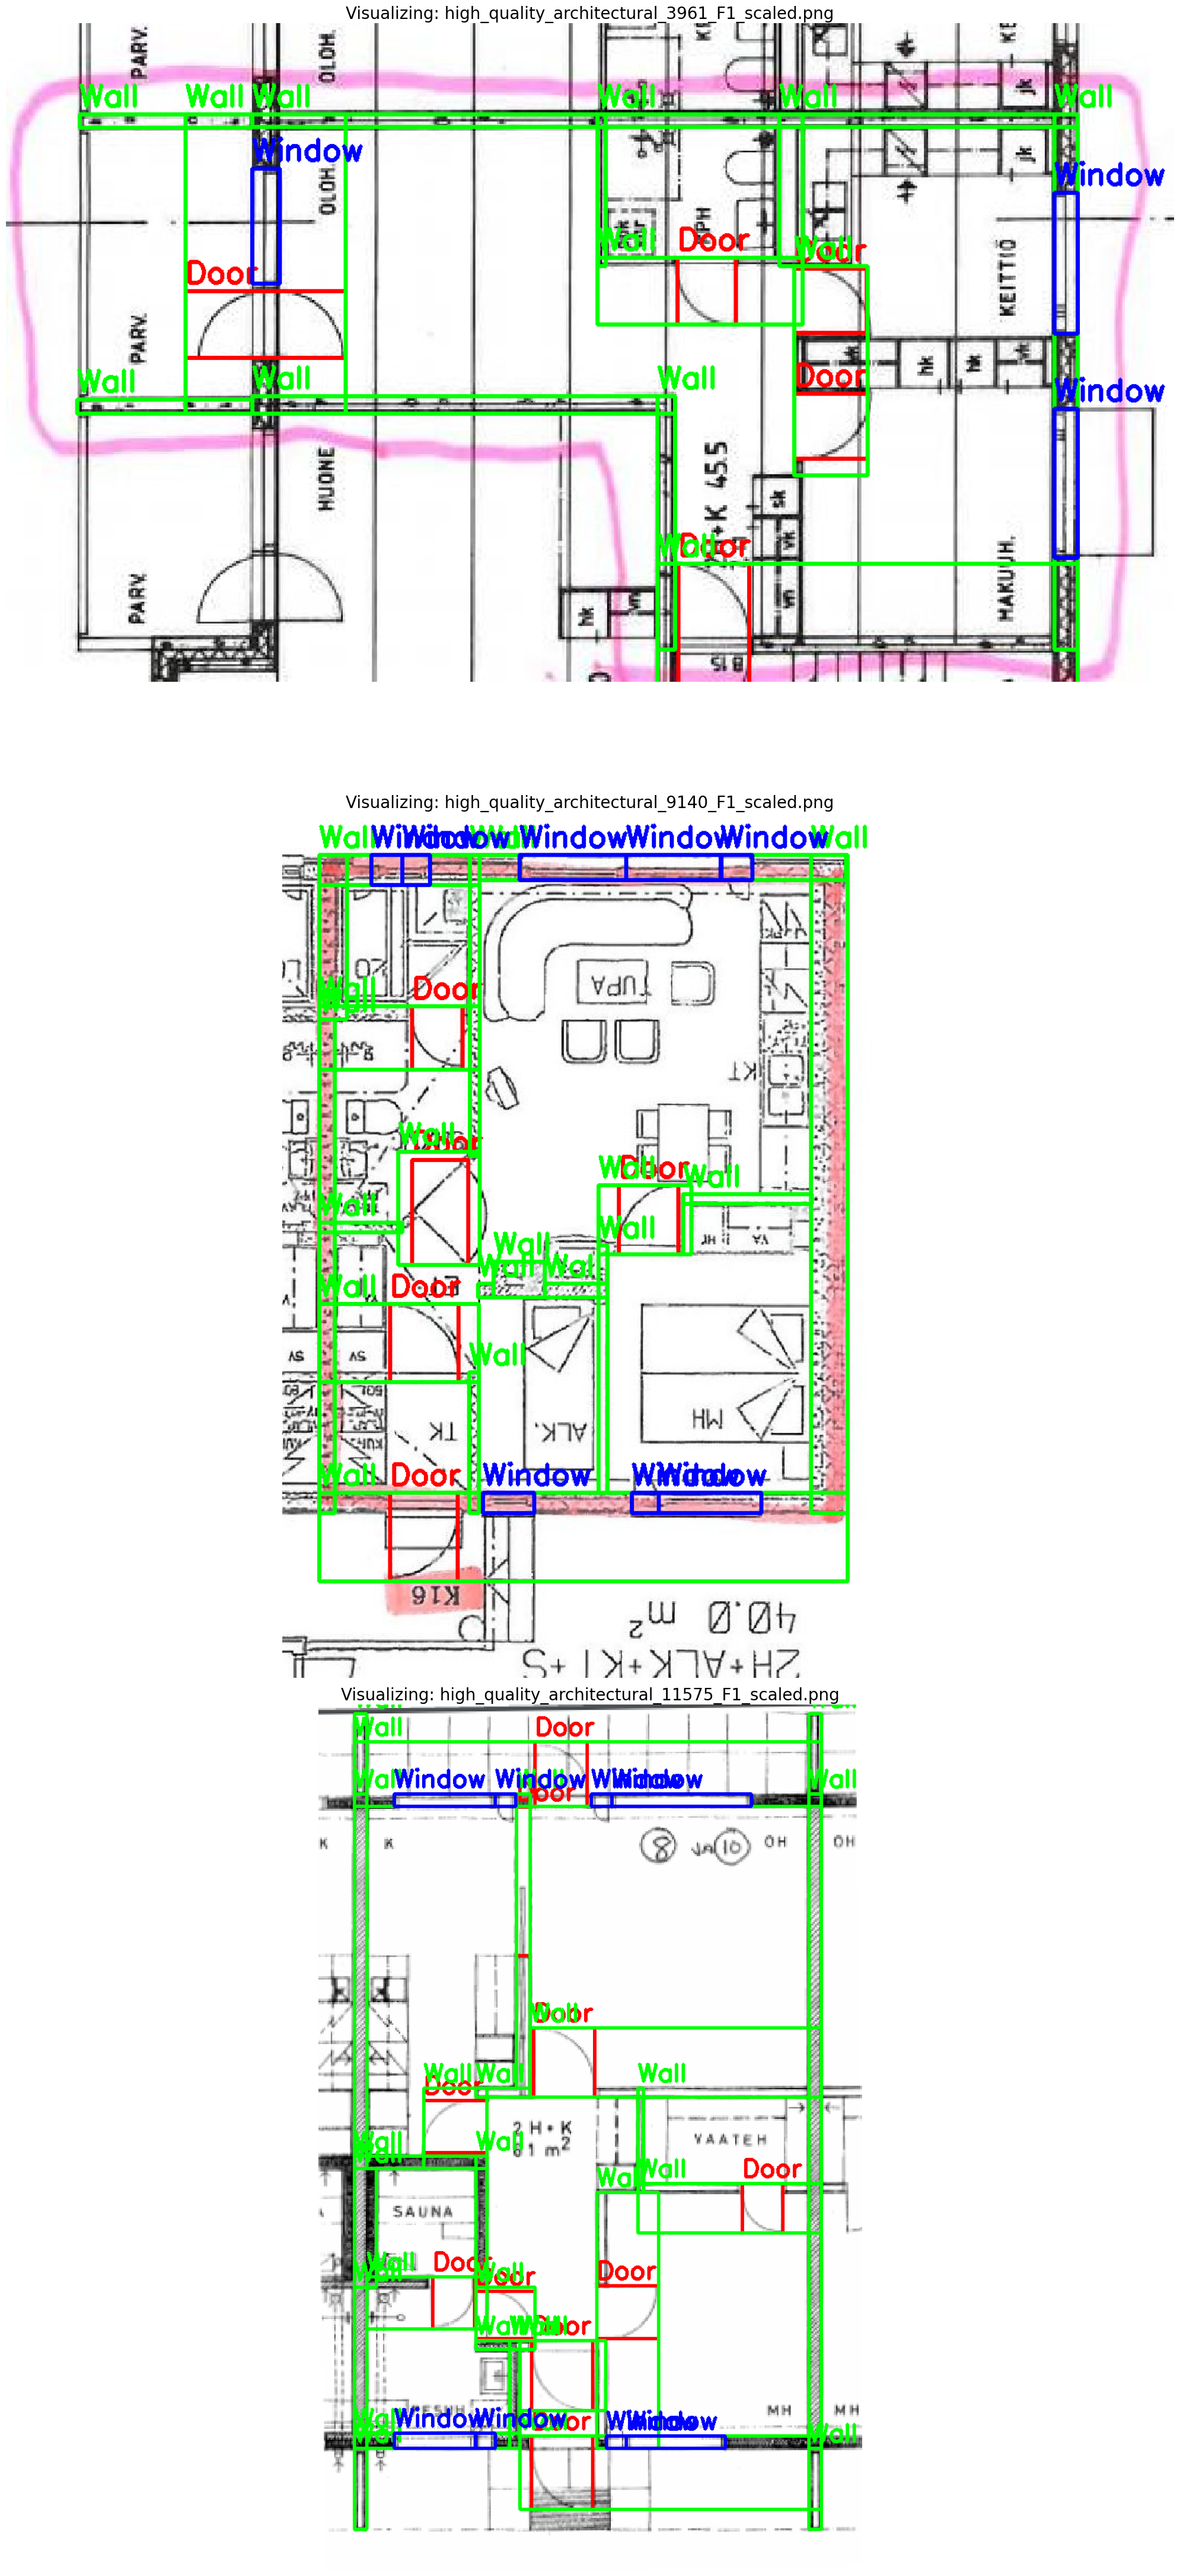

In [3]:
fig, axes = plt.subplots(num_samples, 1, figsize=(20, 15 * num_samples))

if num_samples == 1:
    axes = [axes]

for i, img_p in enumerate(samples):
    # Load image
    img = cv2.imread(str(img_p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    
    # Load labels
    label_p = img_p.with_suffix('.txt')
    if label_p.exists():
        with open(label_p, 'r') as f:
            for line in f:
                parts = line.split()
                if len(parts) != 5:
                    continue
                
                c, cx, cy, bw, bh = map(float, parts)
                
                x1 = int((cx - bw/2) * w)
                y1 = int((cy - bh/2) * h)
                x2 = int((cx + bw/2) * w)
                y2 = int((cy + bh/2) * h)
                
                cls_id = int(c)
                color = colors[cls_id] if cls_id < len(colors) else (255, 255, 255)
                label_text = class_map.get(cls_id, "Unknown")
                
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
                cv2.putText(img, label_text, (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Visualizing: {img_p.name}", fontsize=20)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
flat_dir = Path('cubicasa5k/flat')
colorful_dir = flat_dir / 'colorful'
high_quality_dir = flat_dir / 'high_quality'

In [ ]:
colorful_dir.mkdir(exist_ok=True)
high_quality_dir.mkdir(exist_ok=True)

In [4]:
image_files = [f for f in flat_dir.glob('*.png') if f.is_file()]

print(f"Sorting and renaming {len(image_files)} files...")

c_count = 1
hq_count = 1

for img_path in image_files:
    txt_path = img_path.with_suffix('.txt')
    
    if not txt_path.exists():
        continue
        
    if img_path.name.startswith('colorful'):
        target_folder = colorful_dir
        new_name = f"{c_count}"
        c_count += 1
    else:
        target_folder = high_quality_dir
        new_name = f"{hq_count}"
        hq_count += 1
    
    shutil.move(str(img_path), str(target_folder / f"{new_name}.png"))
    shutil.move(str(txt_path), str(target_folder / f"{new_name}.txt"))

print(f"Done!")
print(f"Colorful: {c_count - 1} pairs")
print(f"High Quality: {hq_count - 1} pairs")

Sorting and renaming 5000 files...
Done!
Colorful: 276 pairs
High Quality: 4724 pairs
